In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#!pip install tensorflow
import tensorflow as tf

In [5]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import load_model

from scipy.special import softmax

from matplotlib.ticker import MultipleLocator

# I will be creating two ensemble models. One combining the HAN model for lyric content with the best song-level lyric sentiment model, Decision Tree Classifier. The other combines the HAN model for lyric content with the best line-level lyric sentiment model, Naives Bayes Classifier.

## A. Base steps applicable to both ensemble models

### 1. Import the data/word2vec/models and set up

#### a. Import the custom word2vec model that I created

In [6]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

#### b. Processing lines into tokens for HAN model

In [7]:
ensemble_han = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [8]:
lyric_lists = [song.splitlines() for song in ensemble_han['Lyrics']]
ensemble_han['Lyrics as Lists'] = lyric_lists
ensemble_han.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [9]:
train_han, val_han = train_test_split(ensemble_han, test_size=0.2, random_state=24, stratify = ensemble_han['Genre'])

In [10]:
train_lyrics = train_han['Lyrics as Lists']
val_lyrics = val_han['Lyrics as Lists']

In [11]:
train_tokenized_lines = [word_tokenize(line.lower()) for lines_list in train_lyrics for line in lines_list]

In [12]:
def lyrics_to_embeddings(lines, model):
    tokenized_lines = [word_tokenize(line.lower()) for line in lines]
    embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
    return embeddings

In [13]:
train_han['Embeddings'] = train_han['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_han['Embeddings'] = val_han['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

#### c. Prepare the data and HAN model for lyric content

All of these steps are explained in detail in the HAN Lyric Contentnotebook

In [14]:
train_han['Genre'] = train_han['Genre'].astype('category').cat.codes
val_han['Genre'] = val_han['Genre'].astype('category').cat.codes

# need to convert genre labels to one-hot encoding to use the keras library
y_train = tf.keras.utils.to_categorical(train_han['Genre'], num_classes=10)
y_val = tf.keras.utils.to_categorical(val_han['Genre'], num_classes=10)

In [15]:
X_train = train_han['Embeddings']
X_val = val_han['Embeddings']

In [16]:
X_train_padded = pad_sequences(X_train, maxlen=300, dtype='float32', padding='post', truncating='post', value=0.0)
X_val_padded = pad_sequences(X_val, maxlen=300, dtype='float32', padding='post', truncating='post', value=0.0)

In [17]:
X_train_array = np.array(X_train_padded)
X_val_array = np.array(X_val_padded)

In [18]:
print("X_train_array shape:", X_train_array.shape)
print("X_val_array shape:", X_val_array.shape)

X_train_array shape: (12000, 300, 100)
X_val_array shape: (3000, 300, 100)


In [19]:
model_han = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_han_content')

## B. Song-Level Lyric sentiment Ensemble Model

### 1. Train the Decision Tree for sentiment

In [20]:
X_train_dtc = train_han['Sentiment']
y_train_dtc = train_han['Genre']

X_val_dtc = val_han['Sentiment']
y_val_dtc = val_han['Genre']

In [21]:
scaler_dtc = StandardScaler()
X_train_dtc = scaler_dtc.fit_transform(np.array(X_train_dtc).reshape(-1,1))
X_val_dtc = scaler_dtc.transform(np.array(X_val_dtc).reshape(-1,1))

In [22]:
model_dtc_sent = DecisionTreeClassifier()
model_dtc_sent.fit(np.array(X_train_dtc).reshape(-1,1), np.array(y_train_dtc).reshape(-1,1))

DecisionTreeClassifier()

### 2. Create and run the blended model

In [128]:
class HANVotingClassifierDTC:
    def __init__(self, models, han_weight=1, dtc_weight=1):
        self.models = models
        self.han_weight = han_weight
        self.dtc_weight = dtc_weight

    def fit(self, X_han, X_dtc, y_han, y_dtc):
        for model_type, model in self.models.items():
            if model_type == "han":
                pass
                #model.fit(X_han, y_han, epochs=4, batch_size=16, validation_split=0.2)
            elif model_type == "dtc":
                model.fit(X_dtc, y_dtc)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_han, X_dtc):
        # Get raw predictions (not probabilities) using the predict method
        han_predictions = self.models["han"].predict(X_han)
        dtc_predictions = self.models["dtc"].predict(X_dtc)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(han_predictions.shape) == 1:
            han_predictions = han_predictions.reshape(-1, 1)

        if len(dtc_predictions.shape) == 1:
            dtc_predictions = dtc_predictions.reshape(-1, 1)

        # Perform the weighted average of raw predictions
        weighted_avg_predictions = (
            self.han_weight * han_predictions + self.dtc_weight * dtc_predictions
        ) / (self.han_weight + self.dtc_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_predictions, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [129]:
ensemble_classifier_han = HANVotingClassifierDTC(models={"han": model_han, "dtc": model_dtc_sent})
ensemble_classifier_han.fit(X_train_array, X_train_dtc, y_train, y_train_dtc)

In [130]:
y_pred = ensemble_classifier_han.predict(X_val_array, X_val_dtc)

94/94 [==============================] - 1s 14ms/step


In [131]:
y_pred

array([3, 0, 6, ..., 6, 3, 2])

In [132]:
y_true = np.argmax(y_val, axis=1)
y_true

array([3, 0, 7, ..., 6, 3, 0])

### 3. Evaluate the model

In [133]:
# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.386


In [135]:
cm = confusion_matrix(y_true, y_pred)

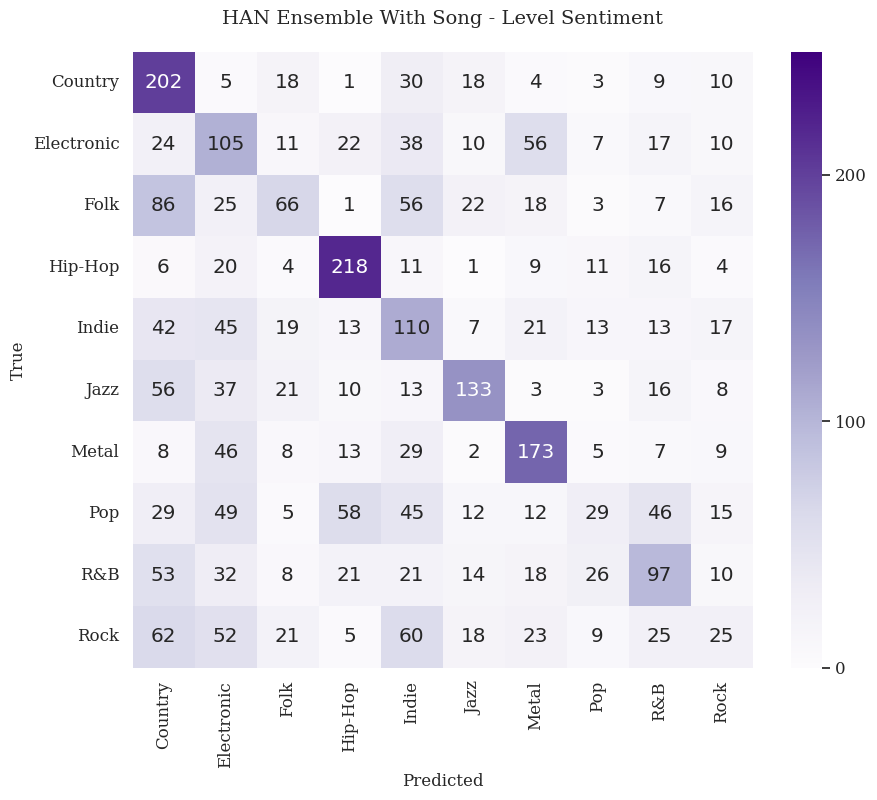

In [136]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Purples',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('HAN Ensemble With Song - Level Sentiment', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/han_ensemble_songlevel.png', bbox_inches='tight')

## C. Line-Level Lyric Semantic Ensemble Models

### 1. Import and pre-process the sentiment data
These steps are outlined more in the lyric sentiment notebook

In [42]:
sent_data_subset_line = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_sentiment_lines_sciclone_complete.csv')

In [43]:
train_han_sent_line, val_han_sent_line = train_test_split(sent_data_subset_line, test_size=0.2, random_state=24, stratify = sent_data_subset_line['Genre'])

In [44]:
X_train_line = np.array(train_han_sent_line['SentimentLines'])
y_train_line = train_han_sent_line['Genre']

X_val_line = np.array(val_han_sent_line['SentimentLines'])
y_val_line = val_han_sent_line['Genre']

In [45]:
X_train_line = np.array([ast.literal_eval(s) for s in X_train_line])
X_val_line = np.array([ast.literal_eval(s) for s in X_val_line])

In [46]:
label_encoder = LabelEncoder()
y_train_line_encoded = label_encoder.fit_transform(y_train_line)
y_train_one_hot = to_categorical(y_train_line_encoded, num_classes=10)

In [47]:
X_train_line = np.array(X_train_line)
y_train_one_hot = np.array(y_train_one_hot)

In [48]:
max_sequence_length = 41
X_train_padded = pad_sequences(X_train_line, maxlen=max_sequence_length, padding='post', truncating='post')

In [49]:
X_train_padded_shifted = X_train_padded + 5

Validation data:

In [50]:
y_val_line_encoded = label_encoder.fit_transform(y_val_line)
y_val_one_hot = to_categorical(y_val_line_encoded, num_classes=10)

In [51]:
X_val_line = np.array(X_val_line)
y_val_one_hot = np.array(y_val_one_hot)

In [52]:
X_val_padded = pad_sequences(X_val_line, maxlen=41, padding='post', truncating='post')
X_val_padded_shifted = X_val_padded + 5

In [53]:
y_train_labels = np.argmax(y_train_one_hot, axis=1)

### 2. Train the Naive Bayes Classifier for Sentiment

In [54]:
scaler_nb = StandardScaler()
X_train_nb = scaler_nb.fit_transform(X_train_padded_shifted)
X_val_nb= scaler_nb.transform(X_val_padded_shifted)

In [55]:
model_nb_sent = GaussianNB()
model_nb_sent.fit(X_train_nb, np.array(y_train_labels))

GaussianNB()

### 3. Create and run the blended model

In [86]:
class HANLSTMVotingClassifierNB:
    def __init__(self, models, han_weight = 2, nb_weight = 1):
        self.models = models
        self.han_weight = han_weight
        self.nb_weight = nb_weight

    def fit(self, X_han, X_nb, y_han, y_nb):
        for model_type, model in self.models.items():
            if model_type == "han":
                pass
                #model.fit(X_han, y_han, epochs=4, batch_size=16, validation_split=0.2)
            elif model_type == "nb":
                model.fit(X_nb, y_nb)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_han, X_nb):
        # Get raw predictions (not probabilities) using the predict method
        han_predictions = self.models["han"].predict(X_han)
        nb_predictions = self.models["nb"].predict(X_nb)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(han_predictions.shape) == 1:
            han_predictions = han_predictions.reshape(-1, 1)

        if len(nb_predictions.shape) == 1:
            nb_predictions = nb_predictions.reshape(-1, 1)

        # Perform the weighted average of raw predictions
        weighted_avg_predictions = (
            self.han_weight * han_predictions + self.nb_weight * nb_predictions
        ) / (self.han_weight + self.nb_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_predictions, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [87]:
model_han = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_han_content')

In [88]:
ensemble_classifier_han_2 = HANLSTMVotingClassifierNB(models={"han": model_han, "nb": model_nb_sent})
ensemble_classifier_han_2.fit(X_train_array, X_train_nb, y_train, y_train_labels)

In [89]:
# Make predictions using the ensemble classifier
y_pred = ensemble_classifier_han_2.predict(X_val_array, X_val_nb)
y_pred

94/94 [==============================] - 2s 12ms/step


array([3, 0, 6, ..., 6, 3, 2])

In [90]:
y_true = np.argmax(y_val, axis=1)
y_true

array([3, 0, 7, ..., 6, 3, 0])

### 4. Evaluate the model

In [91]:
# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.386


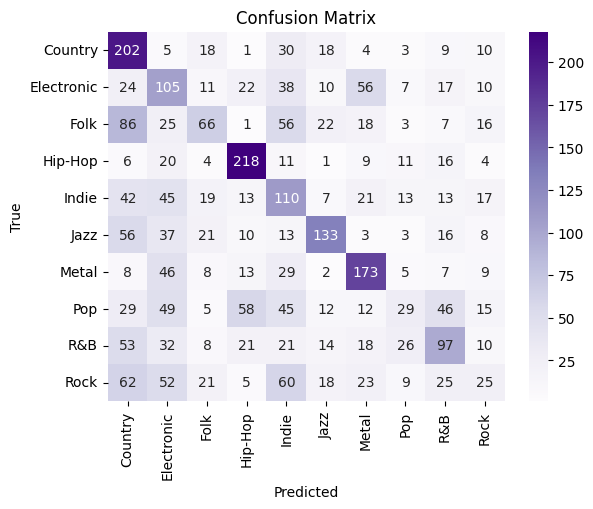

In [92]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 5. Load in RNN for line sentiment

In [94]:
scaler_rnn = StandardScaler()
X_train_rnn = scaler_rnn.fit_transform(X_train_padded_shifted)
X_val_rnn = scaler_rnn.transform(X_val_padded_shifted)

In [114]:
model_rnn = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_sentiment_line_rnn")
model_han = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_han_content')

### 6. Create and Run the Ensemble Model

In [119]:
class HANVotingClassifierRNN:
    def __init__(self, models, han_weight = 1, rnn_weight = 1):
        self.models = models
        self.han_weight = han_weight
        self.rnn_weight = rnn_weight

    def fit(self, X_han, X_rnn, y):
        for model_type, model in self.models.items():
            if model_type == "han":
                pass
                #model.fit(X_han, y_han, epochs=4, batch_size=16, validation_split=0.2)
            elif model_type == "rnn":
                model.fit(X_rnn, y, epochs=5, batch_size=32, validation_split=0.2)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
        return self

    def predict(self, X_han, X_rnn):
        # Get raw predictions (not probabilities) using the predict method
        han_predictions = self.models["han"].predict(X_han)
        rnn_predictions = self.models["rnn"].predict(X_rnn)

        # Check if the predictions are 1D arrays and reshape if necessary
        if len(han_predictions.shape) == 1:
            han_predictions = han_predictions.reshape(-1, 1)

        if len(rnn_predictions.shape) == 1:
            rnn_predictions = rnn_predictions.reshape(-1, 1)

        # Perform the weighted average of raw predictions
        weighted_avg_predictions = (
            self.han_weight * han_predictions + self.rnn_weight * rnn_predictions
        ) / (self.han_weight + self.rnn_weight)

        # Convert raw predictions to class probabilities using softmax
        probabilities = softmax(weighted_avg_predictions, axis=1)

        # Get the class with the maximum probability
        predicted_classes = np.argmax(probabilities, axis=1)

        return predicted_classes

In [122]:
ensemble_classifier_han_rnn = HANVotingClassifierRNN(models={"han": model_han, "rnn": model_rnn})
ensemble_classifier_han_rnn.fit(X_train_array, X_train_rnn, y_train_one_hot)

Epoch 1/5
300/300 [==============================] - 13s 44ms/step - loss: 1.9596 - accuracy: 0.2558 - val_loss: 1.9323 - val_accuracy: 0.2471
Epoch 2/5
300/300 [==============================] - 13s 43ms/step - loss: 1.9405 - accuracy: 0.2610 - val_loss: 1.9214 - val_accuracy: 0.2500
Epoch 3/5
300/300 [==============================] - 9s 29ms/step - loss: 1.9500 - accuracy: 0.2561 - val_loss: 1.9455 - val_accuracy: 0.2446
Epoch 4/5
300/300 [==============================] - 11s 36ms/step - loss: 1.9350 - accuracy: 0.2555 - val_loss: 1.9128 - val_accuracy: 0.2467
Epoch 5/5
300/300 [==============================] - 11s 37ms/step - loss: 1.9351 - accuracy: 0.2619 - val_loss: 1.9026 - val_accuracy: 0.2471


In [112]:
y_pred2 = ensemble_classifier_han_rnn.predict(X_val_array, X_val_rnn)

94/94 [==============================] - 0s 5ms/step


In [106]:
y_val_labels = np.argmax(y_val_one_hot, axis=1)
y_val_labels

array([3, 0, 7, ..., 6, 3, 0])

### 7. Evaluate the Model

In [126]:
# equal weigthing, double trained rnn
accuracy2 = accuracy_score(y_val_labels, y_pred2)
accuracy2

0.43066666666666664

In [125]:
cm = confusion_matrix(y_val_labels, y_pred2)

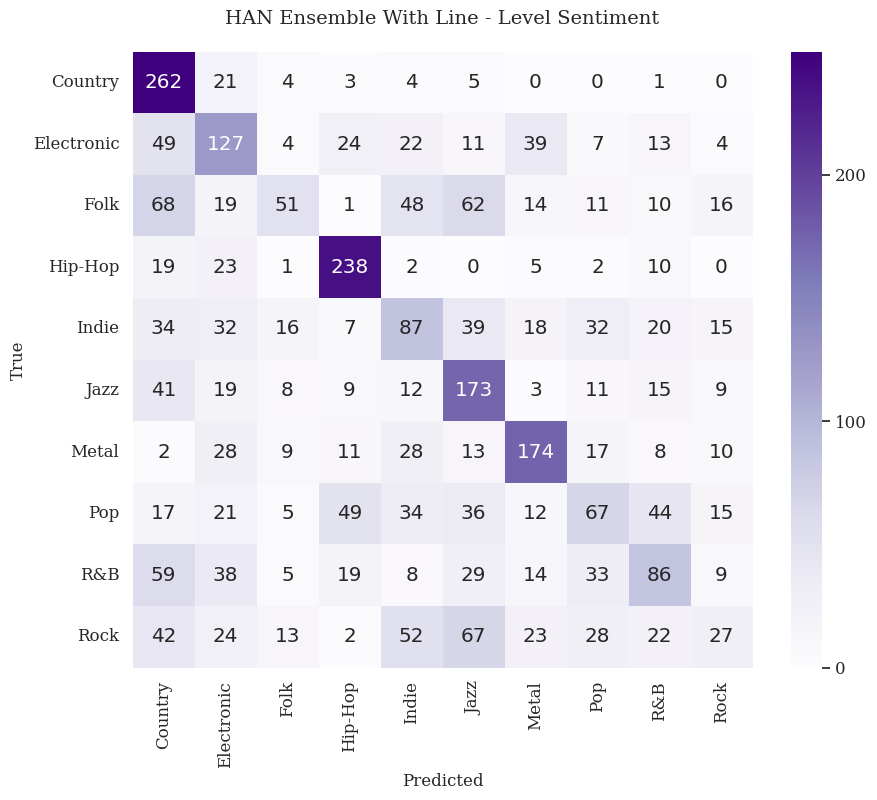

In [127]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Purples',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('HAN Ensemble With Line - Level Sentiment', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/han_ensemble_linelevel.png', bbox_inches='tight')